In [2]:
#importing libraries 
import numpy as np
import torch
from torch.autograd import Function
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms 
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
# to run on GPU for M1 activate virtual environment with:  conda activate torch-nightly 
# torch.device("mps") analogous to torch.device("cuda") on an Nvidia GPU.

#device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
class Timing_function_for(Function):
    @staticmethod
    # ctx is the first argument to forward
    def forward(ctx, input, weight, bias=None):
        #genrate array of sorted index
        input_sorted,sorted_index= torch.sort(input)
        sort= torch.zeros_like(sorted_index[0])
        
        output=torch.zeros(input.shape[0],weight.shape[0])
        contri_weight=torch.zeros(input.shape[0],weight.shape[0],weight.shape[1])
        for i in range(input_sorted.shape[0]):
             sort[sorted_index[i]]=torch.arange(0,input_sorted.shape[1])
             #print(input[i],sort)
             #generate n new arrays with boolean mask from sorted_indices
             weight_broadcast = torch.where(sort.unsqueeze(0) <=torch.arange(0,sort.shape[0]).unsqueeze(1),weight.unsqueeze(1) ,torch.zeros_like(weight).unsqueeze(1))
             #print(weight_broadcast)
             #change weight_broadcast to float
             weight_broadcast = weight_broadcast.float()
             #perform matrix multiplication of input and weight_broadcast
             all_output = ((Vc*C)+ torch.tensordot(input[i],weight_broadcast, dims=([0],[2])))/weight_broadcast.sum(dim=2)
             #print(all_output)
             #find the min of all_output
             min_values,min_indices = torch.min(all_output, dim=1)
            #  print(min_values)
            #  print(min_indices)
             output[i] = min_values
             contri_weight[i] = weight_broadcast[torch.arange(weight_broadcast.size(0)), min_indices].unsqueeze(0)
 
        # The forward pass can use ctx.
        ctx.save_for_backward(input, contri_weight, bias, output)
        # if bias is not None:
        #     output += bias.unsqueeze(0).expand_as(output)
        #print(contri_weight)

        return output
 
    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias, output = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        # print(input)
        # print('weight', weight)
        # print('grad_output', grad_output)
        # print('output', output)
        if ctx.needs_input_grad[0]:
            grad_input = torch.tensordot(grad_output,(weight/weight.sum(dim=2,keepdim=True)), dims=([1],[1]))
            #print(grad_input)
            grad_input = grad_input[torch.eye(weight.shape[0]).bool()]
        if ctx.needs_input_grad[1]:
            grad_weight = (input.unsqueeze(1) - output.unsqueeze(2))/weight.sum(dim=2,keepdim=True) 
            #print(grad_weight)
            grad_weight =torch.tensordot(grad_output,(((input.unsqueeze(1) - output.unsqueeze(2))/weight.sum(dim=2,keepdim=True))* (weight !=0).float()), dims=([0],[0]))
            grad_weight = grad_weight[torch.eye(weight.shape[1]).bool()]
            #print(grad_weight)
        # # if bias is not None and ctx.needs_input_grad[2]:
        # #     grad_bias = grad_output.sum(0)
        # print(weight.sum(dim=2,keepdim=True))
        print(grad_input)
        print(grad_weight)
        return grad_input, grad_weight, grad_bias

In [21]:
class Timing_function(Function):
    @staticmethod
    # ctx is the first argument to forward
    def forward(ctx, input, weight, bias=None):
        #genrate array of sorted index
        input_sorted,sorted_index= torch.sort(input)
        sort= torch.zeros_like(sorted_index)

        sort.scatter_(1,sorted_index,torch.arange(0,input_sorted.shape[1]).repeat(input_sorted.shape[0],1))
        #print(input,sort)
        #generate n new arrays with boolean mask from sorted_indices
        weight_broadcast = torch.where(sort.unsqueeze(1).unsqueeze(1) <=torch.arange(0, sort.shape[1]).unsqueeze(0).unsqueeze(2).unsqueeze(1),weight.unsqueeze(1).unsqueeze(0) ,torch.zeros_like(weight).unsqueeze(1).unsqueeze(0))
        weight_broadcast= weight_broadcast.float()
        # print("weight",weight_broadcast)
        #perform matrix multiplication of input and weight_broadcast
        diagonal = torch.tensordot(input,weight_broadcast, dims=([1],[3]))
        diagonal = diagonal[torch.eye(weight_broadcast.shape[0]).bool()]
        all_output =((Vc*C)+diagonal)/weight_broadcast.sum(dim=3)
        # print(all_output)
        #find the min of all_output
        min_values,min_indices = torch.min(all_output, dim=2)
        # print(min_values)
        #print(min_indices)
        output = min_values
        contri_weight = weight_broadcast[torch.repeat_interleave(torch.arange(weight_broadcast.size(0)),weight_broadcast.size(1)),torch.arange(weight_broadcast.size(1)).repeat(1,weight_broadcast.size(0)),min_indices.view(-1)].reshape(weight_broadcast.shape[0],weight_broadcast.shape[1],weight_broadcast.shape[2])
   
        # The forward pass can use ctx.
        ctx.save_for_backward(input, contri_weight, bias,output)
        # if bias is not None:
        #     output += bias.unsqueeze(0).expand_as(output)
        return output
 
    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias, output = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        # print(input)
        # print('weight', weight)
        # print('grad_output', grad_output)
        # print('output', output)
        if ctx.needs_input_grad[0]:
            grad_input = torch.tensordot(grad_output,(weight/weight.sum(dim=2,keepdim=True)), dims=([1],[1]))
            #print(grad_input)
            grad_input = grad_input[torch.eye(weight.shape[0]).bool()]
        if ctx.needs_input_grad[1]:
            grad_weight = (input.unsqueeze(1) - output.unsqueeze(2))/weight.sum(dim=2,keepdim=True) 
            #print(grad_weight)
            grad_weight =torch.tensordot(grad_output,(((input.unsqueeze(1) - output.unsqueeze(2))/weight.sum(dim=2,keepdim=True))* (weight !=0).float()), dims=([0],[0]))
            grad_weight = grad_weight[torch.eye(weight.shape[1]).bool()]
            #print(grad_weight)
        # # if bias is not None and ctx.needs_input_grad[2]:
        # #     grad_bias = grad_output.sum(0)
        # print(weight.sum(dim=2,keepdim=True))
        #print(grad_input)
        #print(grad_weight)
        return grad_input, grad_weight, grad_bias

In [22]:
#C and VC can be specified to as parameters to the function or declared within the function
C=125
Vc=1
batch_size=torch.randint(1,10, (1,1)).reshape(1)
N=torch.randint(1,10, (1,1)).reshape(1)
M=torch.randint(1,10, (1,1)).reshape(1)
input=torch.rand(batch_size,M,requires_grad=True)
labels= torch.rand(batch_size,N)
weight=torch.rand(N,M)
weight=weight.float()
weight.requires_grad=True

output_for=Timing_function_for.apply(input, weight)
output_new=Timing_function.apply(input, weight)

In [23]:
#verify the output
print('size of batch',batch_size)
print("number of inputs",input.shape[1])
print("number of neurons",weight.shape[0])
print(output_for==output_new)

size of batch tensor([6])
number of inputs 7
number of neurons 2
tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True]])


In [24]:
print('output_for',output_for)
print('output_new',output_new)

output_for tensor([[31.2139, 44.0295],
        [31.1665, 44.0269],
        [31.1063, 43.9856],
        [31.1876, 43.8734],
        [31.2948, 44.1031],
        [31.3840, 44.2910]], grad_fn=<Timing_function_forBackward>)
output_new tensor([[31.2139, 44.0295],
        [31.1665, 44.0269],
        [31.1063, 43.9856],
        [31.1876, 43.8734],
        [31.2948, 44.1031],
        [31.3840, 44.2910]], grad_fn=<Timing_functionBackward>)


In [25]:
criterion = nn.MSELoss(reduce='none')
loss= criterion(output_new,labels)
print('loss',loss)

loss tensor(1410.6644, grad_fn=<MseLossBackward0>)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [26]:
loss.backward(retain_graph=True)

In [27]:
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets

class Downsample(object):
    def __init__(self, size=(10, 10)):
        self.size = size

    def __call__(self, img):
        # Add a batch and channel dimension, resize, then remove batch dimension
        return F.interpolate(img.unsqueeze(0), size=self.size, mode='area').squeeze(0)
    


# Define the transformation pipeline
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    Downsample(size=(10, 10))
])

# Load MNIST dataset with the custom transform
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_pipeline)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=False)



100%|██████████| 9912422/9912422 [00:00<00:00, 38872407.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 92258715.78it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 18944741.07it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11212789.15it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



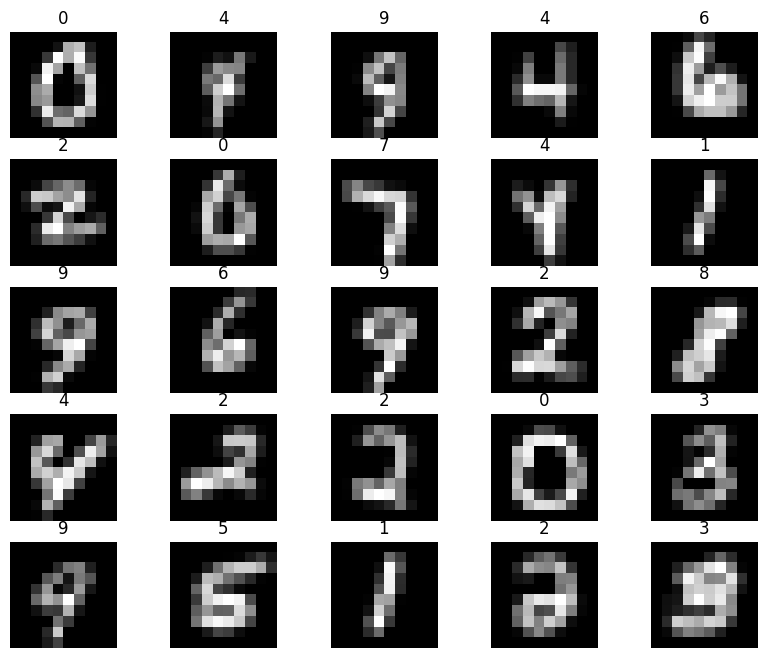

In [28]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_trainset), size=(1,)).item()
    img, label = mnist_trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [29]:
img,label=mnist_trainset[0]

In [83]:
for img,label in train_loader:
    print(img.shape)
    print(label.shape)
    break
print(label.type())

torch.Size([100, 1, 10, 10])
torch.Size([100])
torch.LongTensor


In [30]:
img.shape

torch.Size([1, 10, 10])

In [31]:
class Temporal(nn.Module):
    def __init__(self, input_features, output_features, bias=False):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight1 = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.normal_(self.weight1, 0.5, 0.005)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        out=Timing_function.apply(input, self.weight1, self.bias)
        return out

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

In [713]:
# Create a subset of the first 100 images
subset_indices = list(range(60000))
mnist_subset = Subset(mnist_trainset, subset_indices)

# DataLoader
train_loader = DataLoader(mnist_subset, batch_size=100, shuffle=True)

In [35]:
learning_rate = 0.005
num_epochs = 100
model = Temporal(100,10).to(device)

# Set Loss function with criterion
criterion = nn.MSELoss()


# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

total_step = len(train_loader)

In [36]:
inital_weight=model.weight1.data.clone()

In [37]:
#convert a label from 0 to 9 to a one hot vector
#convert a batch of labels from 0 to 9 to a batch of one hot vectors
def one_hot_batch(labels):
    one_hot_labels=torch.zeros(labels.shape[0],10)
    for i in range(labels.shape[0]):
        one_hot_labels[i][labels[i]]=1
    return one_hot_labels
#time_scale = (C*Vc)/50
time_scale =2

#save weight after each epoch
weight_after_epoch=[]
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        #images = images.type(torch.FloatTensor) # convert the images to float tensors used when running on CPU
        labels = labels.to(device)

        #convert the labels to one hot vectors and add the time scale to the labels
        labels_hot=one_hot_batch(labels)
        labels_hot=labels_hot+time_scale
        #print(labels_hot)
        
        # Forward pass
        #flatted the image to a vector of size 100
        images= images.view(images.size(0), -1)
        outputs = model(images) # Pass the images to the CNN model. images contains the batch size of 10 images and the rest of the dimensions are inferred by the CNN
        loss = criterion(outputs, labels_hot) # Calculate the loss using the loss function criterion which is the cross entropy loss function

        #compute the accuracy of the model
        _, predicted = torch.max(outputs.data, 1) # torch.max returns the maximum value and the index of the maximum value in the tensor. The index of the maximum value is the predicted class
        #print("outputs",outputs)
        #print("predicted",predicted)
        #print("labels",labels)
        correct = (predicted == labels).sum().item() # sum up the number of correct predictions and convert the tensor to a scalar value
        accuracy = correct / labels.size(0) # divide the number of correct predictions by the batch size to get the accuracy of the model
        # the difference between accuracy and loss is that accuracy is the number of correct predictions divided by the batch size and loss is the average loss of the batch
        # Backward and optimize
        optimizer.zero_grad() # zero out the gradients from the previous iteration
        loss.backward() # backpropagate the loss computes the gradients of the loss with respect to the parameters of the model the backward function is called on and take grad_output as the argument which is the gradient of the loss with respect to the output of the model and is computed by the loss function
        optimizer.step() # update the parameters of the model using the gradients computed by the backward function

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    print('Accuracy: {:.2f}%'.format(accuracy*100))
    weight_after_epoch.append(model.weight1.data.clone())

            
            


Epoch [1/100], Loss: 0.1240
Accuracy: 0.00%
Epoch [2/100], Loss: 0.0947
Accuracy: 20.00%
Epoch [3/100], Loss: 0.0909
Accuracy: 0.00%
Epoch [4/100], Loss: 0.0938
Accuracy: 0.00%
Epoch [5/100], Loss: 0.0908
Accuracy: 20.00%
Epoch [6/100], Loss: 0.0926
Accuracy: 10.00%
Epoch [7/100], Loss: 0.0900
Accuracy: 30.00%
Epoch [8/100], Loss: 0.0925
Accuracy: 0.00%
Epoch [9/100], Loss: 0.0910
Accuracy: 0.00%
Epoch [10/100], Loss: 0.0915
Accuracy: 10.00%
Epoch [11/100], Loss: 0.0915
Accuracy: 10.00%
Epoch [12/100], Loss: 0.0916
Accuracy: 0.00%
Epoch [13/100], Loss: 0.0924
Accuracy: 0.00%
Epoch [14/100], Loss: 0.0915
Accuracy: 10.00%
Epoch [15/100], Loss: 0.0913
Accuracy: 10.00%
Epoch [16/100], Loss: 0.0905
Accuracy: 30.00%
Epoch [17/100], Loss: 0.0909
Accuracy: 30.00%
Epoch [18/100], Loss: 0.0903
Accuracy: 10.00%
Epoch [19/100], Loss: 0.0924
Accuracy: 20.00%
Epoch [20/100], Loss: 0.0907
Accuracy: 0.00%
Epoch [21/100], Loss: 0.0909
Accuracy: 10.00%
Epoch [22/100], Loss: 0.0910
Accuracy: 10.00%
Epoch

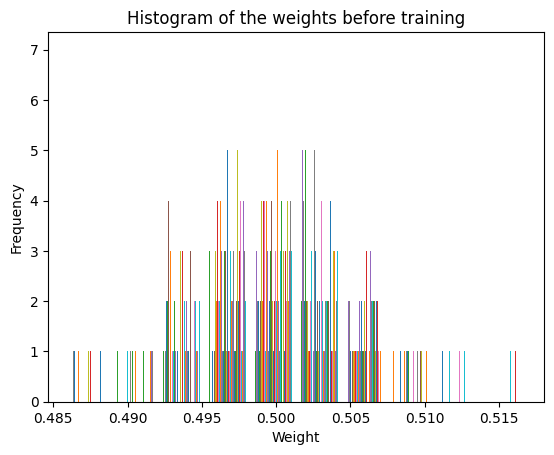

In [47]:
#histogram of the weights before training
plt.hist(inital_weight.cpu().numpy())
plt.title("Histogram of the weights before training")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

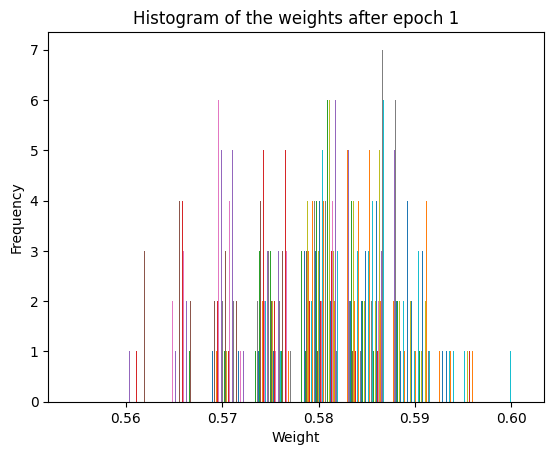

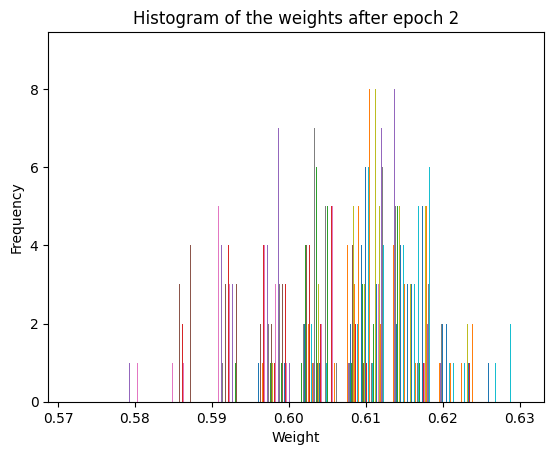

In [48]:
#histogram of weight after first two epochs
for i in range(2):
    plt.hist(weight_after_epoch[i].cpu().numpy())
    plt.title("Histogram of the weights after epoch "+str(i+1))
    plt.xlabel("Weight")
    plt.ylabel("Frequency")
    plt.show()

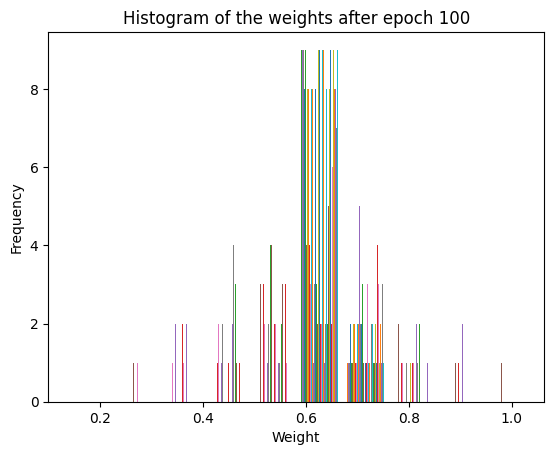

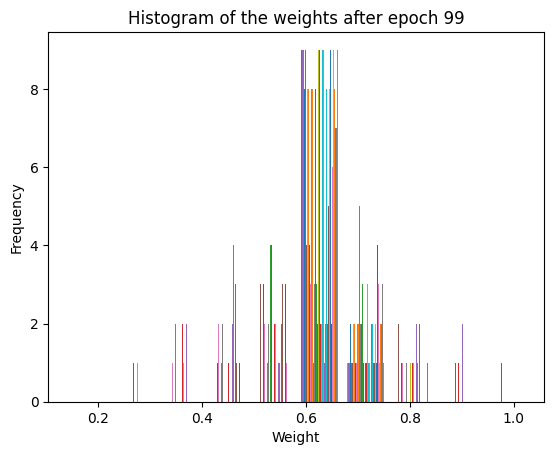

In [49]:
#histogram of weight are last two epochs
for i in range(1,3):
    plt.hist(weight_after_epoch[-i].cpu().numpy())
    plt.title("Histogram of the weights after epoch "+str(num_epochs-i+1))
    plt.xlabel("Weight")
    plt.ylabel("Frequency")
    plt.show()

In [216]:
# Create a subset of the first 100 images
subset_indices = list(range(60000))
mnist_subset = Subset(mnist_trainset, subset_indices)

# DataLoader
train_loader = DataLoader(mnist_subset, batch_size=100, shuffle=True)

#model for 1 output neuron
one_neuron_model=Temporal(10,1).to(device)
#output label is list of 1s size of batch
one_labels=torch.ones(100).long()

learning_rate = 0.01
num_epochs = 4000
# Set Loss function with criterion
criterion = nn.MSELoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(one_neuron_model.parameters(), lr=learning_rate)  

total_step = len(train_loader)

In [217]:
weight_before_training=one_neuron_model.weight1.data.clone()

In [218]:
#create one random input between zero and one and duplicate it to create a batch of 100 inputs
one_input=torch.rand(1,10)
one_input=one_input.repeat(100,1)
one_input.requires_grad=True
one_input.float()

tensor([[0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0.5790, 0.2776, 0.5432, 0.4813, 0.6882, 0.5241, 0.8671, 0.3160, 0.1988,
         0.2498],
        [0

In [219]:
#C and VC can be specified to as parameters to the function or declared within the function
C=4
Vc=1

In [220]:
#convert a label from 0 to 9 to a one hot vector
#convert a batch of labels from 0 to 9 to a batch of one hot vectors
def one_hot_batch(labels):
    one_hot_labels=torch.zeros(labels.shape[0],10)
    for i in range(labels.shape[0]):
        one_hot_labels[i][labels[i]]=1
    return one_hot_labels
#time_scale = (C*Vc)/50
time_scale =-0.2

#save weight after each epoch
one_neuron_model_weight_after_epoch=[]
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i in range(1):
        # Move tensors to the configured device
        images = one_input.to(device)
        #images = images.type(torch.FloatTensor) # convert the images to float tensors used when running on CPU
        labels = one_labels.to(device) #set the labels to 1

        #convert the labels to one hot vectors and add the time scale to the labels
        #labels_hot=one_hot_batch(labels)
        labels_hot=labels+time_scale
        labels_hot=labels_hot.float()
        #print(labels_hot)
        
        # Forward pass
        #flatted the image to a vector of size 100
        #images= images.view(images.size(0), -1)
        outputs = one_neuron_model(images) # Pass the images to the CNN model. images contains the batch size of 10 images and the rest of the dimensions are inferred by the CNN
        loss = criterion(outputs, labels_hot) # Calculate the loss using the loss function criterion which is the cross entropy loss function

        #compute the accuracy of the model
        _, predicted = torch.max(outputs.data, 1) # torch.max returns the maximum value and the index of the maximum value in the tensor. The index of the maximum value is the predicted class
        #print("outputs",outputs)
        #print("predicted",predicted)
        #print("labels",labels)
        correct = (predicted == labels).sum().item() # sum up the number of correct predictions and convert the tensor to a scalar value
        accuracy = correct / labels.size(0) # divide the number of correct predictions by the batch size to get the accuracy of the model
        # the difference between accuracy and loss is that accuracy is the number of correct predictions divided by the batch size and loss is the average loss of the batch
        # Backward and optimize
        optimizer.zero_grad() # zero out the gradients from the previous iteration
        loss.backward() # backpropagate the loss computes the gradients of the loss with respect to the parameters of the model the backward function is called on and take grad_output as the argument which is the gradient of the loss with respect to the output of the model and is computed by the loss function
        optimizer.step() # update the parameters of the model using the gradients computed by the backward function

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    print('Accuracy: {:.2f}%'.format(accuracy*100))
    one_neuron_model_weight_after_epoch.append(one_neuron_model.weight1.data.clone())

            
            


Epoch [1/4000], Loss: 0.2220
Accuracy: 0.00%
Epoch [2/4000], Loss: 0.2196
Accuracy: 0.00%
Epoch [3/4000], Loss: 0.2173
Accuracy: 0.00%
Epoch [4/4000], Loss: 0.2150
Accuracy: 0.00%
Epoch [5/4000], Loss: 0.2128
Accuracy: 0.00%
Epoch [6/4000], Loss: 0.2106
Accuracy: 0.00%
Epoch [7/4000], Loss: 0.2085
Accuracy: 0.00%
Epoch [8/4000], Loss: 0.2064
Accuracy: 0.00%
Epoch [9/4000], Loss: 0.2043
Accuracy: 0.00%
Epoch [10/4000], Loss: 0.2023
Accuracy: 0.00%
Epoch [11/4000], Loss: 0.2004
Accuracy: 0.00%
Epoch [12/4000], Loss: 0.1984
Accuracy: 0.00%
Epoch [13/4000], Loss: 0.1965
Accuracy: 0.00%
Epoch [14/4000], Loss: 0.1947
Accuracy: 0.00%
Epoch [15/4000], Loss: 0.1929
Accuracy: 0.00%
Epoch [16/4000], Loss: 0.1911
Accuracy: 0.00%
Epoch [17/4000], Loss: 0.1894
Accuracy: 0.00%
Epoch [18/4000], Loss: 0.1876
Accuracy: 0.00%
Epoch [19/4000], Loss: 0.1860
Accuracy: 0.00%
Epoch [20/4000], Loss: 0.1843
Accuracy: 0.00%
Epoch [21/4000], Loss: 0.1827
Accuracy: 0.00%
Epoch [22/4000], Loss: 0.1811
Accuracy: 0.0

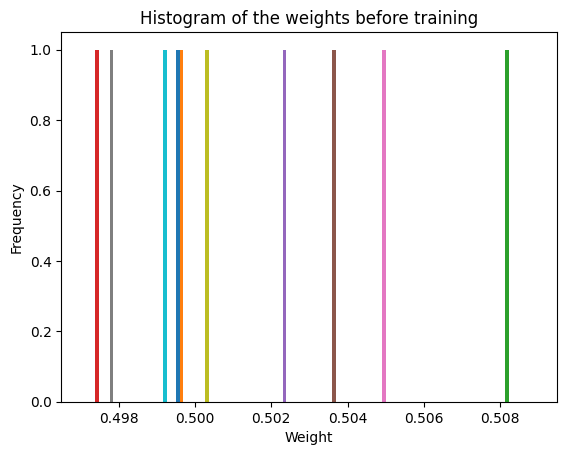

In [221]:
#histogram of the weights before training
plt.hist(weight_before_training.cpu().numpy())
plt.title("Histogram of the weights before training")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

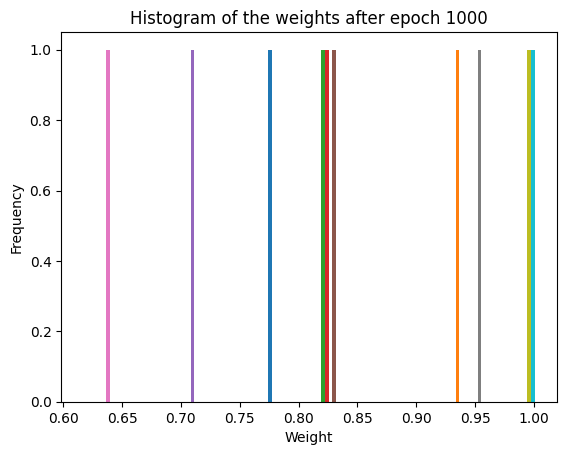

In [222]:
nu=999
plt.hist(one_neuron_model_weight_after_epoch[nu].cpu().numpy())
plt.title("Histogram of the weights after epoch "+str(nu+1))
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

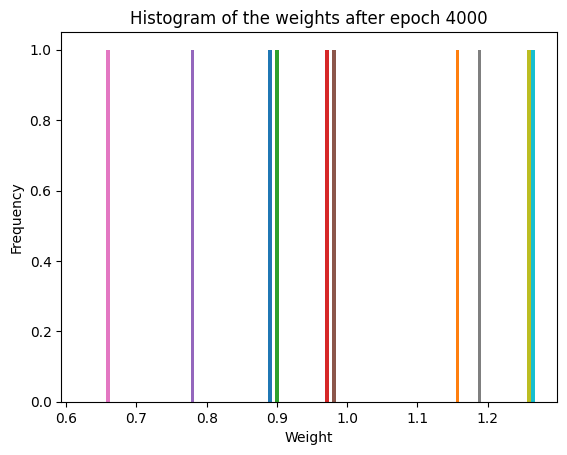

In [223]:
nu=3999
plt.hist(one_neuron_model_weight_after_epoch[nu].cpu().numpy())
plt.title("Histogram of the weights after epoch "+str(nu+1))
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

In [224]:
((C*Vc) +torch.dot(one_input[0],one_neuron_model_weight_after_epoch[nu][0]))/one_neuron_model_weight_after_epoch[nu][0].sum()

tensor(0.8312, grad_fn=<DivBackward0>)

In [167]:
one_neuron_model_weight_after_epoch[63].shape

torch.Size([1, 10])

In [225]:
(C*Vc) /one_neuron_model_weight_after_epoch[nu][0].sum()

tensor(0.3986)

In [226]:
one_neuron_model_weight_after_epoch[nu][0].sum()

tensor(10.0361)